## Analysis

After some research it was discovered that ARIMA models suffer from bunch of nuisances.
Autoregression models seemed to be a good option for this problem. It looks like [fbprophet](https://github.com/facebook/prophet) is a modern library that's fully automatic. This is the main core for this solution.

Main steps

- Convert transaction data to days
- Select companies that have at least 16 days of recorded transactions (we need at least 2 days for prediction, and 14 for validation)
- Select last 14 days for validation and the rest is for training
- Train separate auto-forecasting model for each company
- Predict trained model for each company separately
- Calculate RMSE. (It's possible to estimate standard deviation for this dataset, as prophet estimates errors, but this wasn't implemented for simplicity reasons)

Here is an example (with visualisations) for a single company (with the largest statistics)

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -e ../

In [2]:
from model.model import read_raw
from model.utils import history_test_split
from model.utils import TimeseriesAnalyzer

In [4]:
df = read_raw()
daily = df[["date", "revenue", "company_name"]].groupby(["date", "company_name"], as_index=False).sum()
daily.set_index("date", inplace=True)
daily.head()

,company_name,revenue
date,,
2017-05-12,Accent Co.,66.644923
2017-05-12,Accentforce,7.455298
2017-05-12,Accentpaw,23.015331
2017-05-12,Accentstone,67.888185
2017-05-12,Ace Productions,7.752731


In [5]:
# Select company with largest number of records
core_sports = daily[daily["company_name"] == "Core Sports"]
core_sports.head()

,company_name,revenue
date,,
2017-05-12,Core Sports,299.556155
2017-05-14,Core Sports,18.481313
2017-05-15,Core Sports,61.636602
2017-05-16,Core Sports,16.355786
2017-05-17,Core Sports,11.752513


In [6]:
X_tr, X_te = history_test_split(core_sports, n_days=14)
model = TimeseriesAnalyzer(out="revenue_predicted", y="revenue", daily_seasonality=True)
model.fit(X_tr)
y_te_pred = model.predict(X_te)
print("Train MSE", model.score(X_tr), "Test MSE", model.score(X_te))

Train MSE 367.1828255402427 Test MSE 110.28730404602135


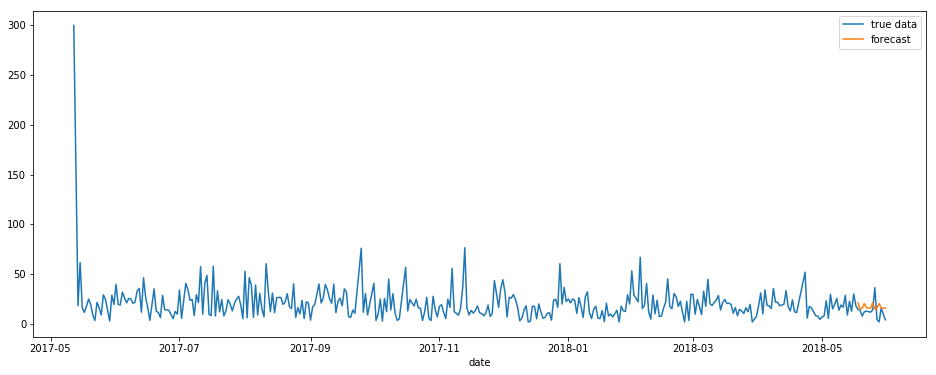

In [7]:
ax = core_sports["revenue"].plot(figsize=(16, 6), label="true data")
y_te_pred.plot(ax=ax, label="forecast")
ax.legend()

So, one can see that prediction roughly represents overall trend. This analysis was repeated for all companies that heave enough records.